In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

In [2]:
taxiDB = pd.read_csv('taxi_dataset.csv')

In [3]:
taxiDB.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N


Column description:

- id - Trip ID;
- vendor_id - ID of the company carrying out transportation;
- pickup_datetime - Trip start timecode;
- dropoff_datetime - End of trip timecode;
- passenger_count - Number of passengers;
- pickup_longitude - Longitude of the point where the trip started;
- pickup_latitude - Latitude of the point where the trip started;
- dropoff_longitude - Longitude of the point where the trip ended
- dropoff_latitude - Latitude of the point where the trip ended;
- store_and_fwd_flag - Yes/No: Was information saved in the vehicle's memory due to a loss of connection to the server?

Target - trip duration.

In [4]:
taxiDB['trip_duration'] = (pd.to_datetime(taxiDB['dropoff_datetime']) - \
                           pd.to_datetime(taxiDB['pickup_datetime'])).dt.total_seconds()

taxiDB.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0


When predicting targets for new objects in the future, we will not know the dropoff_datetime in advance.

Let's remove the column from the dataset.

In [5]:
taxiDB = taxiDB.drop('dropoff_datetime', axis=1)

In [6]:
taxiDB.shape

(1458644, 10)

We have a binary feature vendor_id, taking the values {1, 2}. Let's translate it into the set {0, 1}, since this is simply more familiar.

In [7]:
taxiDB['vendor_id'] = taxiDB['vendor_id'] - 1

In [8]:
taxiDB['store_and_fwd_flag'] = taxiDB['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

taxiDB.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455.0
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663.0
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124.0
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429.0
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435.0


Let's start converting each longitude into some relative kilometer expression

Let's collect a list of all latitudes (both starting and ending points).

In [9]:
allLat  = list(taxiDB['pickup_latitude']) + list(taxiDB['dropoff_latitude'])

In [10]:
#median
medianLat  = sorted(allLat)[int(len(allLat)/2)]

Now, for each latitude value, subtract the median value.

Let's convert the result to kilometers

In [11]:
latMultiplier  = 111.32

taxiDB['pickup_latitude'] = latMultiplier * (taxiDB['pickup_latitude'] - medianLat)
taxiDB['dropoff_latitude'] = latMultiplier * (taxiDB['dropoff_latitude'] - medianLat)

In [12]:
taxiDB.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,1.516008,-73.964630,1.256121,0,455.0
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,-1.753813,-73.999481,-2.578912,0,663.0
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,1.070973,-74.005333,-4.923841,0,2124.0
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,-3.823568,-74.012268,-5.298809,0,429.0
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,4.329328,-73.972923,3.139453,0,435.0


In total, the following expressions were obtained for the latitude speakers:

Approximately how many kilometers north or south (depending on the sign) is the point relative to the average latitude?

In [13]:
allLong = list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude'])

medianLong  = sorted(allLong)[int(len(allLong)/2)]

longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

Using the resulting median and the multiplier by which all longitudes should be adjusted, obtain the correct longitude characteristics by analogy.

In [14]:
taxiDB['pickup_longitude']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dropoff_longitude']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

taxiDB.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,1,2016-03-14 17:24:55,1,-0.110015,1.516008,1.367786,1.256121,0,455.0
1,id2377394,0,2016-06-12 00:43:35,1,0.036672,-1.753813,-1.571088,-2.578912,0,663.0
2,id3858529,1,2016-01-19 11:35:24,1,0.153763,1.070973,-2.064547,-4.923841,0,2124.0
3,id3504673,1,2016-04-06 19:32:31,1,-2.461500,-3.823568,-2.649362,-5.298809,0,429.0
4,id2181028,1,2016-03-26 13:30:55,1,0.657515,4.329328,0.668452,3.139453,0,435.0


Finally, let's calculate the geographic distance 'distance_km':

In [15]:
taxiDB['long_diff'] = taxiDB['dropoff_longitude'] - taxiDB['pickup_longitude']
taxiDB['lat_diff'] = taxiDB['dropoff_latitude'] - taxiDB['pickup_latitude']

taxiDB['distance_km'] = (taxiDB['long_diff']**2 + taxiDB['lat_diff']**2)**(1/2)

taxiDB = taxiDB.drop(['long_diff', 'lat_diff'], axis=1)

In [16]:
taxiDB.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km
0,id2875421,1,2016-03-14 17:24:55,1,-0.110015,1.516008,1.367786,1.256121,0,455.0,1.500479
1,id2377394,0,2016-06-12 00:43:35,1,0.036672,-1.753813,-1.571088,-2.578912,0,663.0,1.807119
2,id3858529,1,2016-01-19 11:35:24,1,0.153763,1.070973,-2.064547,-4.923841,0,2124.0,6.392080
3,id3504673,1,2016-04-06 19:32:31,1,-2.461500,-3.823568,-2.649362,-5.298809,0,429.0,1.487155
4,id2181028,1,2016-03-26 13:30:55,1,0.657515,4.329328,0.668452,3.139453,0,435.0,1.189925


Let's remove the old features!

In [17]:
taxiDB = taxiDB.drop(['pickup_longitude', 'dropoff_longitude',
                      'pickup_latitude', 'dropoff_latitude'], axis=1)

taxiDB.head()

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance_km
0,id2875421,1,2016-03-14 17:24:55,1,0,455.0,1.500479
1,id2377394,0,2016-06-12 00:43:35,1,0,663.0,1.807119
2,id3858529,1,2016-01-19 11:35:24,1,0,2124.0,6.392080
3,id3504673,1,2016-04-06 19:32:31,1,0,429.0,1.487155
4,id2181028,1,2016-03-26 13:30:55,1,0,435.0,1.189925


In [18]:
taxiDB['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Let's work with this feature as a categorical one and implement Mean-target encoding

In [19]:
taxiDB['passenger_count'] = taxiDB['passenger_count'].map(taxiDB
                                                          .groupby('passenger_count')['trip_duration']
                                                          .mean())

In [20]:
taxiDB = taxiDB.set_index('id')
taxiDB.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,,
id2875421,1,2016-03-14 17:24:55,930.399753,0,455.0,1.500479
id2377394,0,2016-06-12 00:43:35,930.399753,0,663.0,1.807119
id3858529,1,2016-01-19 11:35:24,930.399753,0,2124.0,6.392080
id3504673,1,2016-04-06 19:32:31,930.399753,0,429.0,1.487155
id2181028,1,2016-03-26 13:30:55,930.399753,0,435.0,1.189925


We will measure MSLE. It can be shown that to optimize MSLE it is enough to take the logarithm of the target variable, and then optimize the usual MSE

In [21]:
taxiDB = taxiDB.assign(log_trip_duration=np.log1p(taxiDB['trip_duration']))
taxiDB = taxiDB.drop('trip_duration', axis=1)

In [22]:
taxiDB.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration
id,,,,,,
id2875421,1,2016-03-14 17:24:55,930.399753,0,1.500479,6.122493
id2377394,0,2016-06-12 00:43:35,930.399753,0,1.807119,6.498282
id3858529,1,2016-01-19 11:35:24,930.399753,0,6.392080,7.661527
id3504673,1,2016-04-06 19:32:31,930.399753,0,1.487155,6.063785
id2181028,1,2016-03-26 13:30:55,930.399753,0,1.189925,6.077642


It seems that depending on the month/day of the week/time of day, traffic on the roads can be different. Both due to weather conditions and traffic congestion. Therefore, I suspect that it will be useful to extract a number of features from the pickup_datetime column. Let's explore the dependence of our target variable on these factors.

In [23]:
taxiDB['pickup_datetime'] = pd.to_datetime(taxiDB['pickup_datetime'])

### date, day, hour, month
taxiDB['date'] = taxiDB.pickup_datetime.dt.date
taxiDB['day_of_week'] = taxiDB.pickup_datetime.dt.dayofweek
taxiDB['hour'] = taxiDB.pickup_datetime.dt.hour
taxiDB['month'] = taxiDB.pickup_datetime.dt.month

In [24]:
taxiDB.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,date,day_of_week,hour,month
id,,,,,,,,,,
id2875421,1,2016-03-14 17:24:55,930.399753,0,1.500479,6.122493,2016-03-14,0,17,3
id2377394,0,2016-06-12 00:43:35,930.399753,0,1.807119,6.498282,2016-06-12,6,0,6
id3858529,1,2016-01-19 11:35:24,930.399753,0,6.392080,7.661527,2016-01-19,1,11,1
id3504673,1,2016-04-06 19:32:31,930.399753,0,1.487155,6.063785,2016-04-06,2,19,4
id2181028,1,2016-03-26 13:30:55,930.399753,0,1.189925,6.077642,2016-03-26,5,13,3


We investigate when and how many trips were made.

Let's start with graphs showing the number of trips depending on the time of day/date, etc.

It is also useful to immediately show the average value of the target variable.

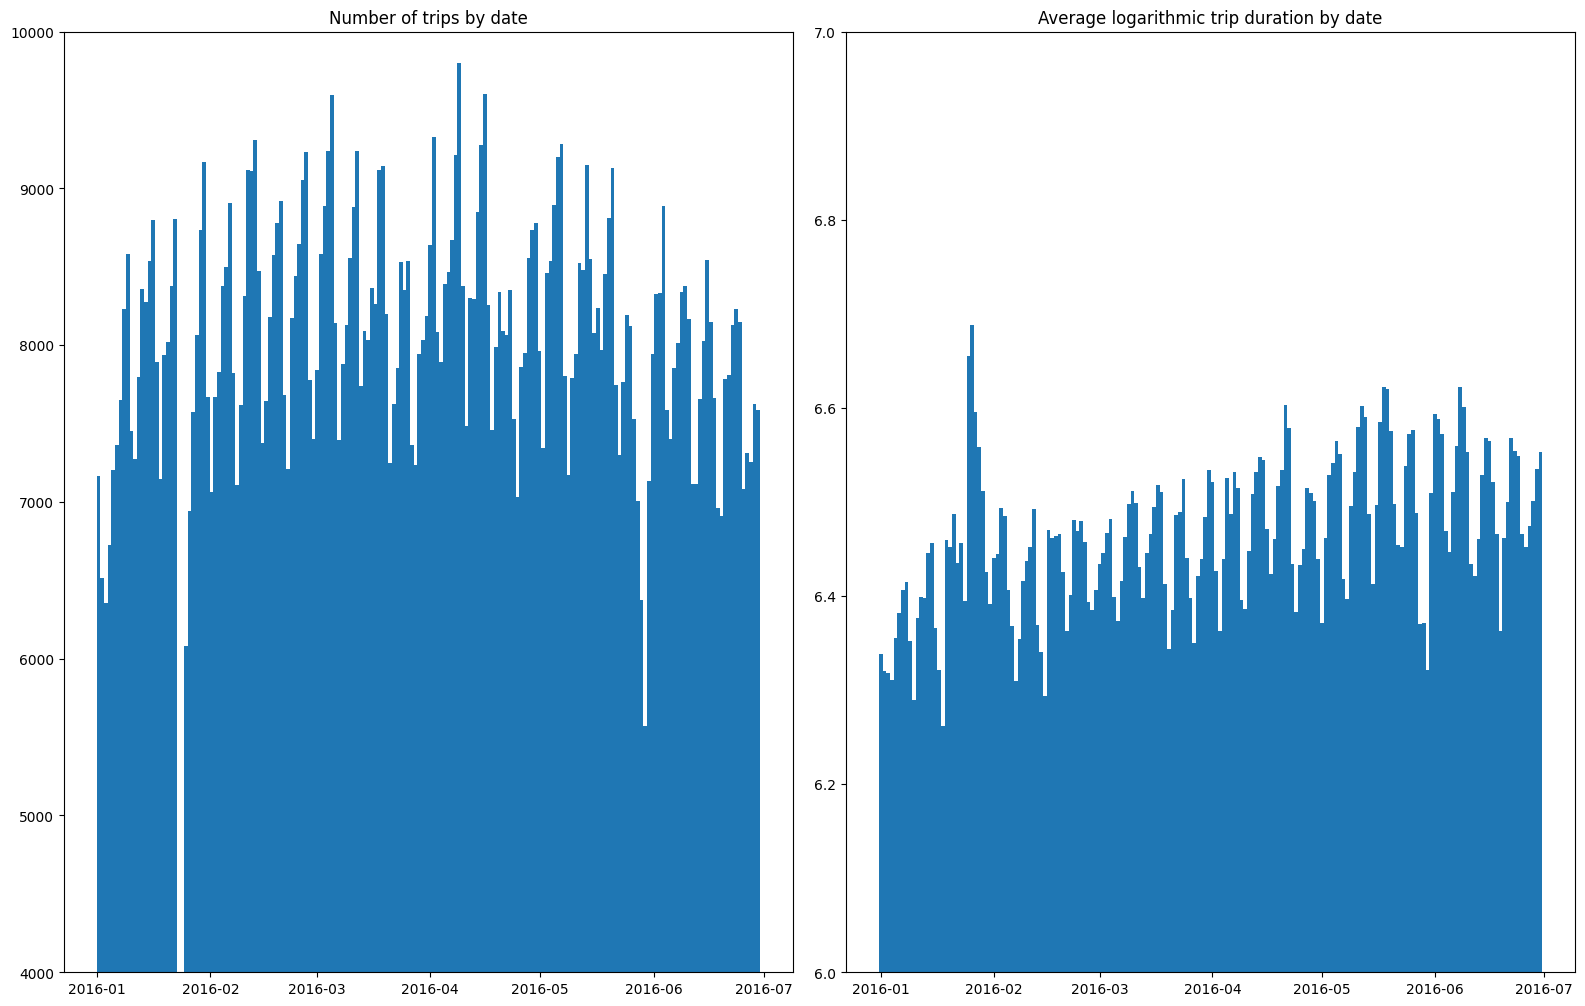

In [25]:
fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(1, 2, 1)
plt.hist(taxiDB['date'], bins=taxiDB.date.unique().shape[0])
plt.ylim((4000, 10000))

ax_2 = fig.add_subplot(1, 2, 2)
plt.bar(sorted(list(taxiDB['date'].unique())), 
        taxiDB.groupby('date', as_index=False)['log_trip_duration'].mean()['log_trip_duration'],
        width=1)
plt.ylim((6, 7))

fig.tight_layout()

ax_1.set(title = 'Number of trips by date')
ax_2.set(title = 'Average logarithmic trip duration by date')

plt.show()

It seems that within a week there is some dependence of the target on the day of the week.

The same dependence may appear within the day (depending on the hours).

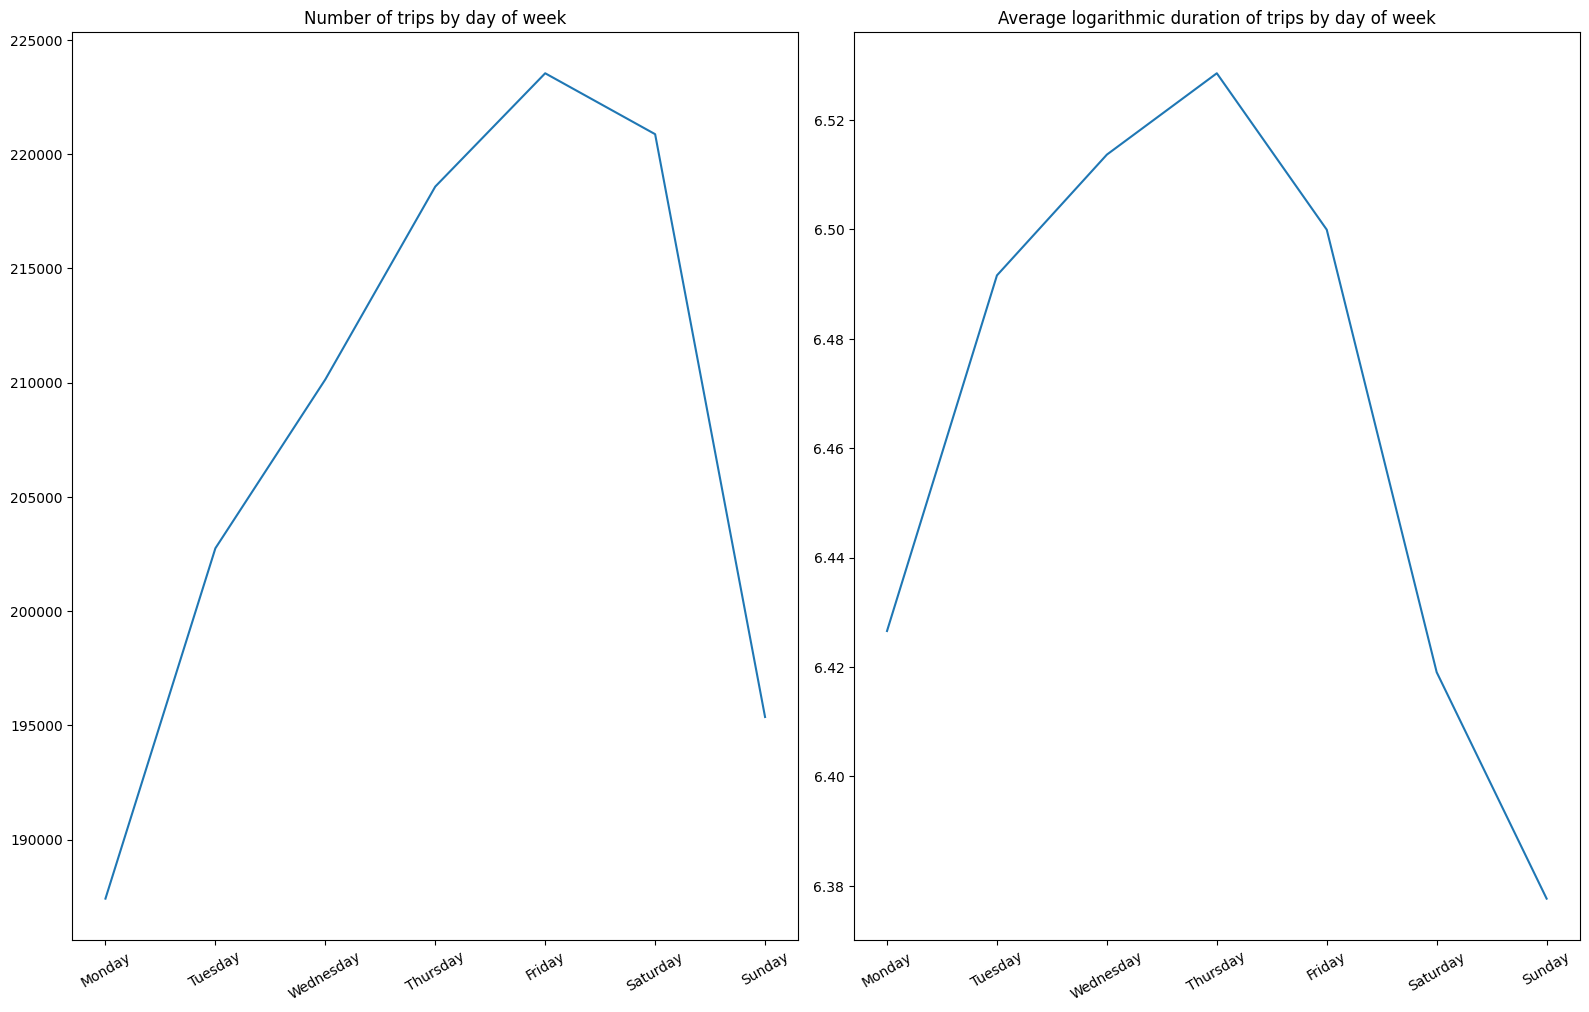

In [26]:
### Let's plot the number of trips and the average target by day of the week

fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(taxiDB.groupby(['day_of_week']).size())
plt.xticks(range(7), 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(taxiDB.groupby('day_of_week')['log_trip_duration'].mean())
plt.xticks(range(7), 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
           rotation=30)

fig.tight_layout()

ax_1.set(title = 'Number of trips by day of week')
ax_2.set(title = 'Average logarithmic duration of trips by day of week')

plt.show()

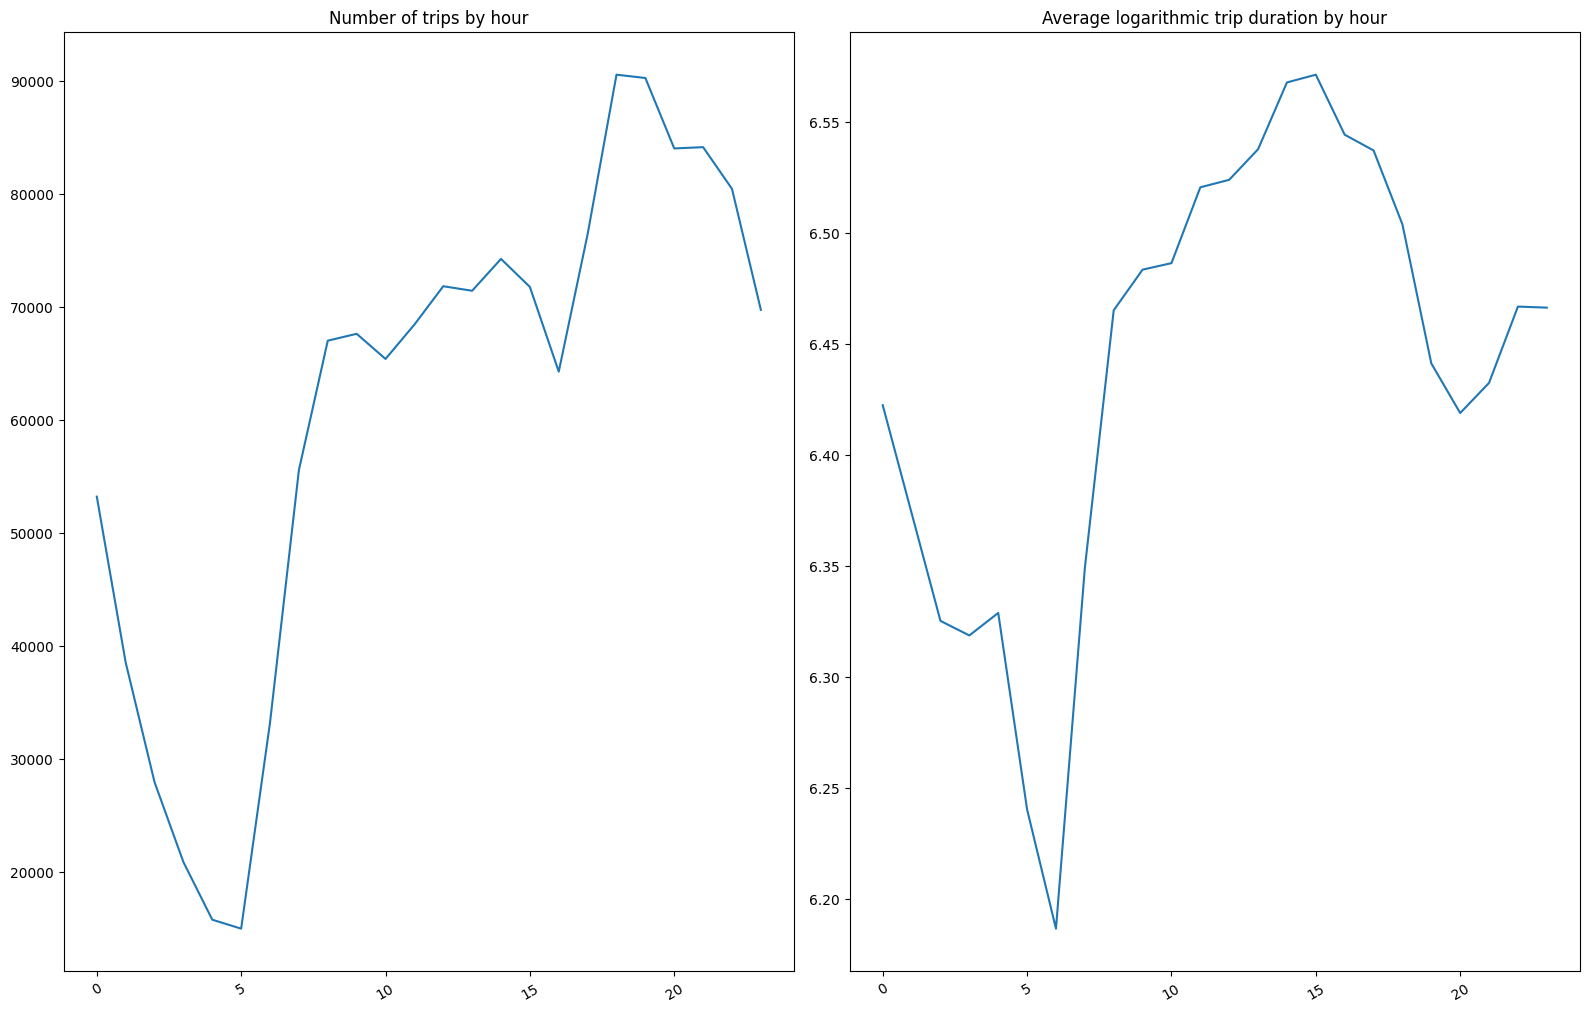

In [27]:
### Let's build graphs of the number of trips and the average target by hour

fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(taxiDB.groupby(['hour']).size())
plt.xticks(rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(taxiDB.groupby('hour')['log_trip_duration'].mean())
plt.xticks(rotation=30)

fig.tight_layout()

ax_1.set(title = 'Number of trips by hour')
ax_2.set(title = 'Average logarithmic trip duration by hour')

plt.show()

↑↑↑ It can be seen that the number of trips in a certain period of time and the average target value corresponding to this period are strongly and positively related

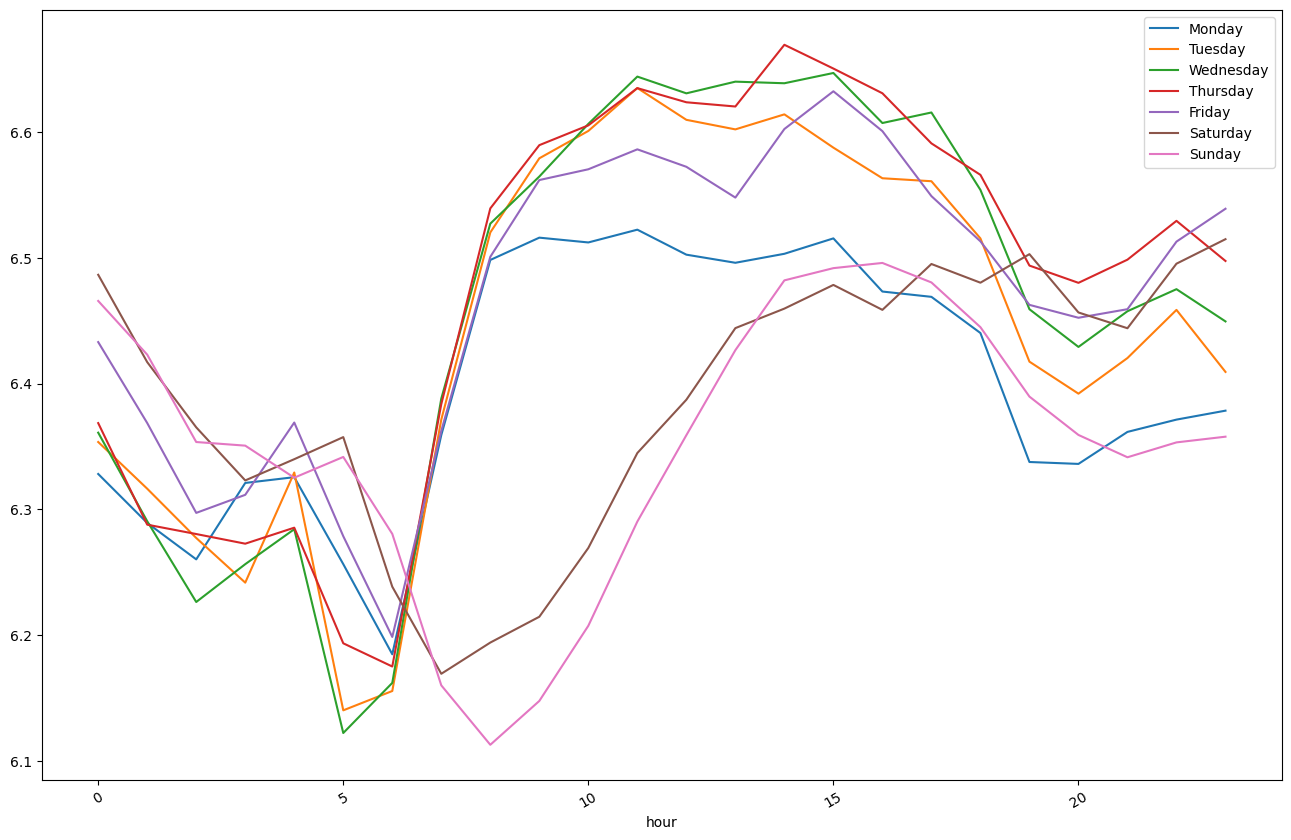

In [28]:
### Let's build average target curves hourly for each day of the week

frame = taxiDB.groupby(['day_of_week', 'hour'], as_index=False)['log_trip_duration'].mean()
frame = frame.pivot(index='hour', columns='day_of_week', values='log_trip_duration')
frame.plot(figsize=(16, 10))

plt.xticks(rotation=30)

plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

↑↑↑ It can be seen that rush hour almost always occurs during working hours on almost any day of the week, around 13-15 hours.

In [29]:
### Let's depict the same thing in the form of a heat map to understand the workload within the days of the week

frame.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

frame.style.background_gradient(cmap='RdPu')

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,6.328173,6.353598,6.361024,6.368642,6.433067,6.486600,6.465794
1,6.289221,6.316450,6.290582,6.287852,6.368686,6.417126,6.423073
2,6.260257,6.277271,6.226347,6.280400,6.297224,6.365256,6.353585
3,6.321038,6.241751,6.256435,6.272725,6.311585,6.323040,6.350705
4,6.325626,6.329338,6.284243,6.285450,6.369078,6.339929,6.325216
5,6.256471,6.140184,6.122148,6.193495,6.278671,6.357487,6.341709
6,6.184772,6.155556,6.162004,6.175040,6.198555,6.238505,6.280519
7,6.359147,6.371453,6.388129,6.383752,6.362452,6.169255,6.160052
8,6.498381,6.520274,6.527269,6.539392,6.500891,6.194081,6.112782


↑↑↑ Let's find the whitest area among the lines. It can be seen that this is the morning time on weekdays around 5-6 o’clock (a little later on weekends)

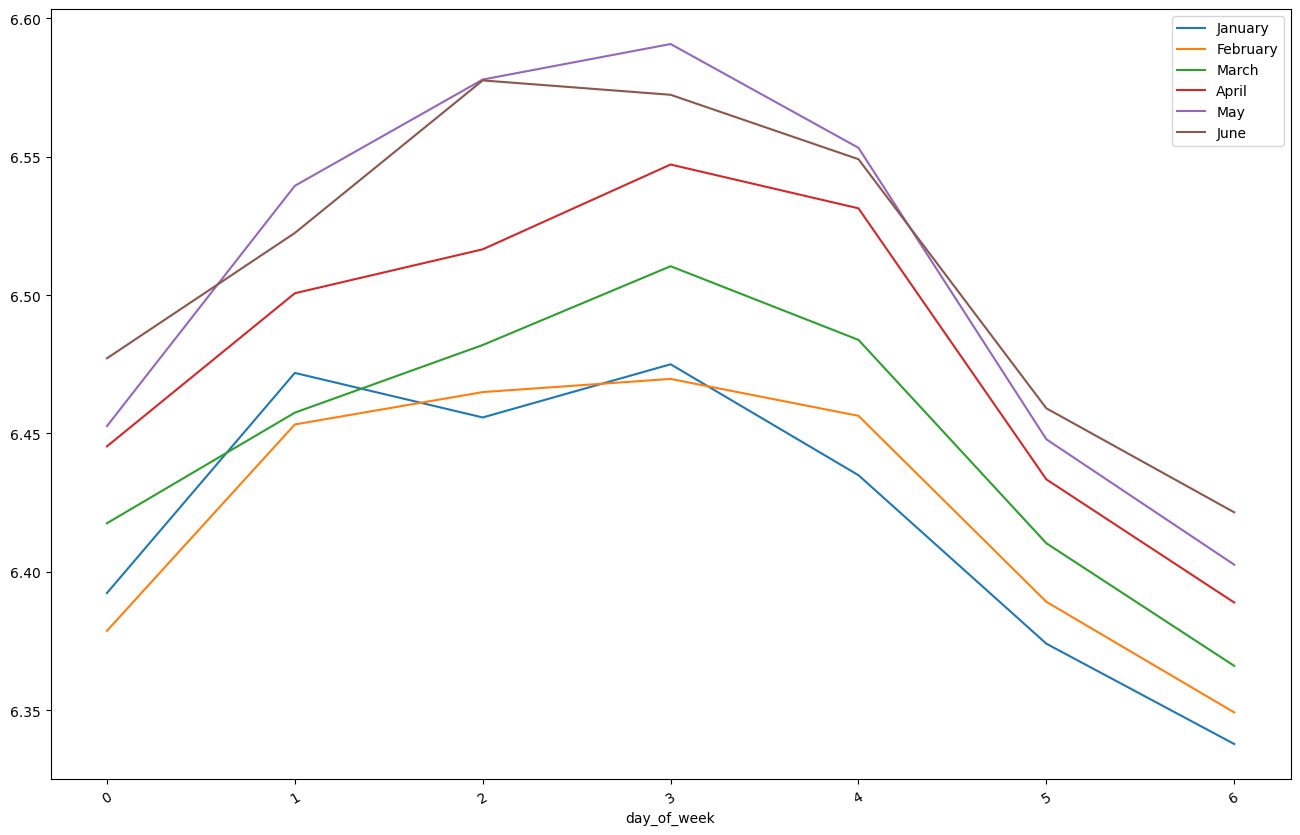

In [30]:
### And now for each month by day of the week

frame_2 = taxiDB.groupby(['month', 'day_of_week'], as_index=False)['log_trip_duration'].mean()
frame_2 = frame_2.pivot(index='day_of_week', columns='month', values='log_trip_duration')
frame_2.plot(figsize=(16, 10))

plt.xticks(rotation=30)

plt.legend(['January', 'February', 'March', 'April', 'May', 'June'])

plt.show()

↑↑↑ Let's find the heaviest months (with the highest target values on average by day of the week). It turns out that it will be May and June

↑↑↑ This also shows that from one day of the week to another, the average target values change (and for all months) --> The distribution of the target variable for each day of the week is different. This is obvious at least from the differences in average values.

It seems that the findings from the graphs above are sufficient to consider the features associated with the time/date of travel to be quite important. Based on them, we will highlight a couple more.

Let's add the following binary features:

Was there a storm on the day of travel (based on the only such day found)
Is travel time statistically the most problematic, i.e. rush hour?
To create the 2nd feature, we use the following logic: we calculate the average target value for each “day of the week” - “time of day” pair. Let's find the top 10 "biggest" pairs. If the trip was made during this top time, then set it to 1. Otherwise, set it to 0. This results in a binary attribute.

In [31]:
### Let's create the first binary attribute

taxiDB['anomaly'] = 0
taxiDB.loc[taxiDB.date.apply(str)=='2016-01-23', 'anomaly'] = 1

In [32]:
### Let's create a second binary attribute

frame = taxiDB.groupby(['day_of_week', 'hour'], as_index=False)['log_trip_duration'].mean()
frame = frame.pivot(index='hour', columns='day_of_week', values='log_trip_duration')

taxiDB['traffic_jam'] = 0

for x in frame.unstack().sort_values(ascending=False).index[:10]:

    taxiDB.loc[(taxiDB.day_of_week==x[0])&(taxiDB.hour==x[1]), 'traffic_jam'] = 1


In [33]:
taxiDB.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,date,day_of_week,hour,month,anomaly,traffic_jam
id,,,,,,,,,,,,
id2875421,1,2016-03-14 17:24:55,930.399753,0,1.500479,6.122493,2016-03-14,0,17,3,0,0
id2377394,0,2016-06-12 00:43:35,930.399753,0,1.807119,6.498282,2016-06-12,6,0,6,0,0
id3858529,1,2016-01-19 11:35:24,930.399753,0,6.392080,7.661527,2016-01-19,1,11,1,0,1
id3504673,1,2016-04-06 19:32:31,930.399753,0,1.487155,6.063785,2016-04-06,2,19,4,0,0
id2181028,1,2016-03-26 13:30:55,930.399753,0,1.189925,6.077642,2016-03-26,5,13,3,0,0


Now the pickup_datetime, date columns can be removed. And you need to think about the remaining day_of_week, hour, month:

On the one hand, the first two can be removed, since the traffic_jam column was created on their basis
On the other hand, the dependence with the traffic_jam column is non-linear, so you can try to use all the features in combination. Of course, it’s better to try both options and experiment, but for the sake of simplicity, let’s leave all the columns. Although day_of_week, hour are described by numbers, we understand that these are rather categorical features. Because, for example, the relationship between 23:00 and 00:00 is not the same as between the numbers 23 and 0. Let's encode them using OneHotEncoder.
The last one (month) is obviously categorical. You can also encode it via OneHotEncoder.

In [34]:
taxiDB = taxiDB.drop(['pickup_datetime', 'date'], axis=1)

In [35]:
taxiDB.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,day_of_week,hour,month,anomaly,traffic_jam
id,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,17,3,0,0
id2377394,0,930.399753,0,1.807119,6.498282,6,0,6,0,0
id3858529,1,930.399753,0,6.392080,7.661527,1,11,1,0,1
id3504673,1,930.399753,0,1.487155,6.063785,2,19,4,0,0
id2181028,1,930.399753,0,1.189925,6.077642,5,13,3,0,0


In [36]:
for col in ['day_of_week', 'hour', 'month']:
    onehot = pd.get_dummies(taxiDB[col], drop_first=True)
    onehot.columns = [f"{col}_{x}" for x in onehot.columns]
    
    taxiDB = pd.concat((taxiDB, onehot), axis=1)
    taxiDB = taxiDB.drop(col, axis=1)

Let's apply correlation analysis for one pair of features to understand whether there is an excess of information regarding these columns in our dataset.

In [37]:
taxiDB[['passenger_count', 'distance_km']].corr()

### There is no reason, the correlation is close to 0

,passenger_count,distance_km
passenger_count,1.000000,0.016596
distance_km,0.016596,1.000000


In [38]:
res = taxiDB.head()

In [39]:
res.shape

(5, 41)

In [40]:
selector = KFold(n_splits=4, shuffle=True, random_state=33)

### Let's build an ordinary linear regression model and measure the quality using the established cross-validation

model = LinearRegression()

X = taxiDB.drop('log_trip_duration', axis=1)
Y = taxiDB['log_trip_duration']

cv_result_1 = cross_validate(model, X, Y, 
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error = -np.mean(cv_result_1['test_score'])

print(f"RMSLE on Cross Validation: {round(cross_val_error, 3)}")

RMSLE on Cross Validation: 0.408


Let's analyze the emissions!

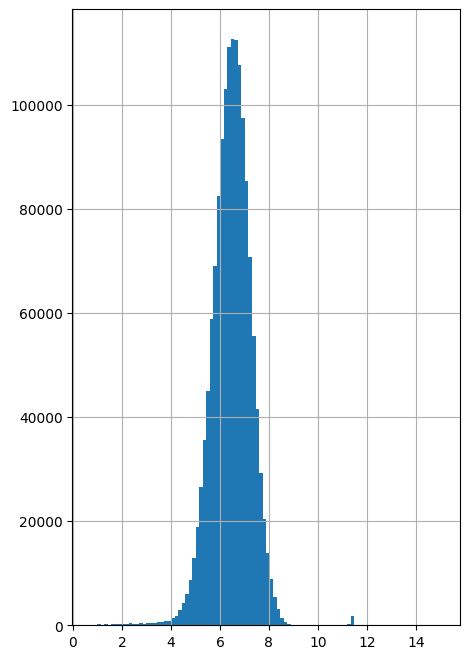

In [41]:
fig = plt.figure()
fig.set_size_inches((5, 8))

taxiDB["log_trip_duration"].hist(bins=100)

plt.show()

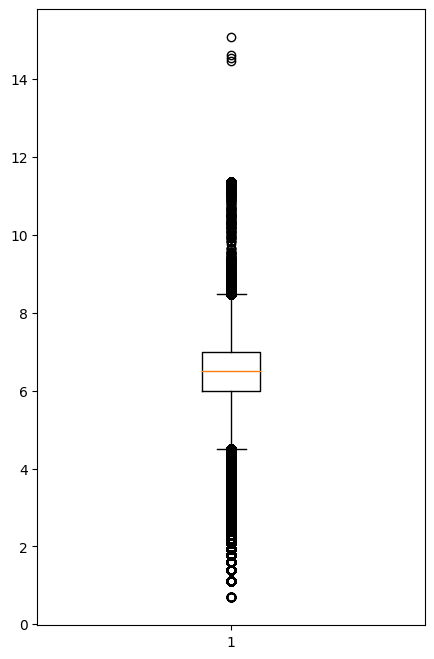

In [42]:
fig = plt.figure()

fig.set_size_inches((5, 8))

plt.boxplot(taxiDB['log_trip_duration'].values)

plt.show()

Let's clean them up by removing those objects whose targets are outside the gap (top 99.5% value; top 0.5% value)

In [43]:
### Let's save top99.5% and top0.5% values into variables top05, top995

top05 = taxiDB.log_trip_duration.quantile(0.995)
top995 =  taxiDB.log_trip_duration.quantile(0.005)

### Let’s remove from the dataset all objects with a target outside the values obtained above

taxiDB = taxiDB[(taxiDB.log_trip_duration < top05)&(taxiDB.log_trip_duration > top995)]

In [44]:
### Let's repeat the code with quality measurements on the resulting dataset

X = taxiDB.drop('log_trip_duration', axis=1)
Y = taxiDB['log_trip_duration']

cv_result_2 = cross_validate(model, X, Y, 
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error_2 = -np.mean(cv_result_2['test_score'])

print(f"RMSLE on Cross Validation: {round(cross_val_error_2, 3)}")

RMSLE on Cross Validation: 0.327


The quality has definitely improved! It is, of course, worth understanding that if there were outliers in the training set, and they are expected in the new data, then by removing the outliers from the train, we will get even larger errors on the new outliers. Is it important for us to obtain adequate forecasts for anomalous objects?